---
title: Entrenar una red Pix2pix usando pytorch en la base de datos facades
format:
 pdf:
   documentclass: report
   page-orientation: landscape
   number_sections: true
   pdf-enngine: xelatex
   geometry:
     - top=30mm
     - left=20mm
     - heightrounded
monofont: VictorMono Nerd Font Mono
monofontoptions:
 - Scale=0.6
author: Brandon Marquez Salazar
jupyter:
 jupytext:
   text_representation:
     extension: .qmd
     format_name: quarto
     format_version: '1.0'
     jupytext_version: 1.17.2
 kernelspec:
   display_name: Python 3
   language: python
   name: python3
---

## Modelo CycleGAN

El modelo CycleGAN es un tipo de GAN que transforma una imagen de un dominio a otro sin requerir de pares de imágenes etiquetadas.

La CycleGAN consta de:

*   **Red generadora**. La red generadora toma como entrada una imagen de un dominio (p. ej., un caballo) y genera como salida una imagen de otro dominio (p.ej., una zebra).
*   **Red discriminadora**. La red discriminadora es un clasificador que recibe como entrada una imagen y entrega a la salida un score de clasificación en dos clases: imagen real e imagen generada.

Las dos redes son entrenadas simultáneamente compitiendo la una contra la otra en un juego de mínimo y máximo.

 Lo que hace diferente a la CycleGAN es la introducción de una función de pérdida de consistencia de ciclo. Esta función de pérdida asegura que la imagen transformada sea mapeada de regreso a la imagen original, cuando es pasada por la red generadora en sentido inverso.
 <img src='https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-05_at_3.54.24_PM_aoT8JRU.png' height=400px>

## Modelo Pix2Pix

 El modelo Pix2Pix es un modelo generativo que utiliza una GAN condicional para transformar una imagen de un dominio a otro usando para su entrenamiento pares de imágenes etiquetadas. El modelo Pix2Pix sobresale en tareas donde el mapeo de las imágenes está bien definido.

 Al igual que la CycleGAN, el modelo Pix2Pix consta de una red generadora y una red discriminadora. La red generadora recibe como entrada una imagen y genera la imagen correspondiente, mientras que la red discriminadora distingue entre imágenes reales e imágenes generadas. Ambas redes son entrenadas de manera adversarial para mejorar la calidad de las imágenes generadas.
<img src='https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-05_at_12.37.47_PM_dZrgNzj.png' height=300px>


## Instalar e importar módulos a utilizar

In [ ]:
import sys
import os
import imp
try:
   imp.find_module('wandb')
   found = True
except ImportError:
   found = False
   %pip install wandb -q
   pass
import random
import numpy as np
import torch
import torch.nn as nn
from torch.nn import init
import itertools
import functools
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
import torch.utils.data
from tensorflow.keras.utils import get_file
import pathlib
from abc import ABC, abstractmethod
from collections import OrderedDict
from PIL import Image
import time
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from IPython import display
import wandb

## Declarar clase para almacenar imágenes generadas

In [ ]:
class ImagePool():
   """This class implements an image buffer that stores previously generated images.
   This buffer enables us to update discriminators using a history of generated images
   rather than the ones produced by the latest generators.
   """

   def __init__(self, pool_size):
       """Initialize the ImagePool class
       Parameters:
           pool_size (int) -- the size of image buffer, if pool_size=0, no buffer will be created
       """
       self.pool_size = pool_size
       # create an empty pool
       if self.pool_size > 0:              self.num_imgs = 0
           self.images = []

   def query(self, images):
       """Return an image from the pool.
       Parameters:
           images: the latest generated images from the generator
       Returns images from the buffer.
       By 50/100, the buffer will return input images.
       By 50/100, the buffer will return images previously stored in the buffer,
       and insert the current images to the buffer.
       """
       # if the buffer size is 0, do nothing
       if self.pool_size == 0:              return images
       return_images = []
       for image in images:
           image = torch.unsqueeze(image.data, 0)
           # if the buffer is not full; keep inserting current images to the buffer
           if self.num_imgs < self.pool_size:                   self.num_imgs = self.num_imgs + 1
               self.images.append(image)
               return_images.append(image)
           else:
               p = random.uniform(0, 1)
               # by 50% chance, the buffer will return a previously stored image, and insert the current image into the buffer
               if p > 0.5:                      random_id = random.randint(0, self.pool_size - 1)  # randint is inclusive
                   tmp = self.images[random_id].clone()
                   self.images[random_id] = image
                   return_images.append(tmp)
               # by another 50% chance, the buffer will return the current image
               else:                           return_images.append(image)
       # collect all the images and return
       return_images = torch.cat(return_images, 0)           return return_images

## Declarar funciones y clases para usarse en la creación de las arquitecturas

In [ ]:
#@title
###############################################################################
# Helper Functions
###############################################################################

class networks:
 class Identity(nn.Module):
     def forward(self, x):
         return x

 @staticmethod
 def get_norm_layer(norm_type='instance'):
     """Return a normalization layer
     Parameters:
         norm_type (str) -- the name of the normalization layer: batch | instance | none
     For BatchNorm, we use learnable affine parameters and track running statistics (mean/stddev).
     For InstanceNorm, we do not use learnable affine parameters. We do not track running statistics.
     """
     if norm_type == 'batch':
         norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
     elif norm_type == 'instance':
         norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
     elif norm_type == 'none':
         def norm_layer(x): return networks.Identity()
     else:
         raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
     return norm_layer

 @staticmethod
 def get_scheduler(optimizer, opt):
     """Return a learning rate scheduler
     Parameters:
         optimizer          -- the optimizer of the network
         opt (option class) -- stores all the experiment flags; needs to be a subclass of BaseOptions．
                               opt.lr_policy is the name of learning rate policy: linear | step | plateau | cosine
     For 'linear', we keep the same learning rate for the first <opt.n_epochs> epochs
     and linearly decay the rate to zero over the next <opt.n_epochs_decay> epochs.
     For other schedulers (step, plateau, and cosine), we use the default PyTorch schedulers.
     See https://pytorch.org/docs/stable/optim.html for more details.
     """
     if opt.lr_policy == 'linear':
         def lambda_rule(epoch):
             lr_l = 1.0 - max(0, epoch + opt.epoch_count - opt.n_epochs) / float(opt.n_epochs_decay + 1)
             return lr_l
         scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
     elif opt.lr_policy == 'step':
         scheduler = lr_scheduler.StepLR(optimizer, step_size=opt.lr_decay_iters, gamma=0.1)
     elif opt.lr_policy == 'plateau':
         scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, threshold=0.01, patience=5)
     elif opt.lr_policy == 'cosine':
         scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=opt.n_epochs, eta_min=0)
     else:
         return NotImplementedError('learning rate policy [%s] is not implemented', opt.lr_policy)
     return scheduler

 @staticmethod
 def init_weights(net, init_type='normal', init_gain=0.02):
     """Initialize network weights.
     Parameters:
         net (network)   -- network to be initialized
         init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
         init_gain (float)    -- scaling factor for normal, xavier and orthogonal.
     We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
     work better for some applications. Feel free to try yourself.
     """
     # define the initialization function
     def init_func(m):            classname = m.__class__.__name__
         if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
             if init_type == 'normal':
                 init.normal_(m.weight.data, 0.0, init_gain)
             elif init_type == 'xavier':
                 init.xavier_normal_(m.weight.data, gain=init_gain)
             elif init_type == 'kaiming':
                 init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
             elif init_type == 'orthogonal':
                 init.orthogonal_(m.weight.data, gain=init_gain)
             else:
                 raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
             if hasattr(m, 'bias') and m.bias is not None:
                 init.constant_(m.bias.data, 0.0)
         # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
         elif classname.find('BatchNorm2d') != -1:                init.normal_(m.weight.data, 1.0, init_gain)
             init.constant_(m.bias.data, 0.0)

     print('initialize network with %s' % init_type)
     # apply the initialization function <init_func>
     net.apply(init_func)  
 @staticmethod
 def init_net(net, init_type='normal', init_gain=0.02, gpu_ids=[]):
     """Initialize a network: 1. register CPU/GPU device (with multi-GPU support); 2. initialize the network weights
     Parameters:
         net (network)      -- the network to be initialized
         init_type (str)    -- the name of an initialization method: normal | xavier | kaiming | orthogonal
         gain (float)       -- scaling factor for normal, xavier and orthogonal.
         gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2
     Return an initialized network.
     """
     if len(gpu_ids) > 0:
         assert(torch.cuda.is_available())
         net.to(gpu_ids[0])
         # multi-GPUs
         net = torch.nn.DataParallel(net, gpu_ids)        networks.init_weights(net, init_type, init_gain=init_gain)
     return net

 @staticmethod
 def define_G(input_nc, output_nc, ngf, netG, norm='batch', use_dropout=False, init_type='normal', init_gain=0.02, gpu_ids=[]):
     """Create a generator
     Parameters:
         input_nc (int) -- the number of channels in input images
         output_nc (int) -- the number of channels in output images
         ngf (int) -- the number of filters in the last conv layer
         netG (str) -- the architecture's name: resnet_9blocks | resnet_6blocks | unet_256 | unet_128
         norm (str) -- the name of normalization layers used in the network: batch | instance | none
         use_dropout (bool) -- if use dropout layers.
         init_type (str)    -- the name of our initialization method.
         init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
         gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2
     Returns a generator
     Our current implementation provides two types of generators:
         U-Net: [unet_128] (for 128x128 input images) and [unet_256] (for 256x256 input images)
         The original U-Net paper: https://arxiv.org/abs/1505.04597
         Resnet-based generator: [resnet_6blocks] (with 6 Resnet blocks) and [resnet_9blocks] (with 9 Resnet blocks)
         Resnet-based generator consists of several Resnet blocks between a few downsampling/upsampling operations.
         We adapt Torch code from Justin Johnson's neural style transfer project (https://github.com/jcjohnson/fast-neural-style).
     The generator has been initialized by <init_net>. It uses RELU for non-linearity.
     """
     net = None
     norm_layer = networks.get_norm_layer(norm_type=norm)

     if netG == 'resnet_9blocks':
         net = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=9)
     elif netG == 'resnet_6blocks':
         net = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=6)
     elif netG == 'unet_128':
         net = UnetGenerator(input_nc, output_nc, 7, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
     elif netG == 'unet_256':
         net = UnetGenerator(input_nc, output_nc, 8, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
     else:
         raise NotImplementedError('Generator model name [%s] is not recognized' % netG)
     return networks.init_net(net, init_type, init_gain, gpu_ids)

 @staticmethod
 def define_D(input_nc, ndf, netD, n_layers_D=3, norm='batch', init_type='normal', init_gain=0.02, gpu_ids=[]):
     """Create a discriminator
     Parameters:
         input_nc (int)     -- the number of channels in input images
         ndf (int)          -- the number of filters in the first conv layer
         netD (str)         -- the architecture's name: basic | n_layers | pixel
         n_layers_D (int)   -- the number of conv layers in the discriminator; effective when netD=='n_layers'
         norm (str)         -- the type of normalization layers used in the network.
         init_type (str)    -- the name of the initialization method.
         init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
         gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2
     Returns a discriminator
     Our current implementation provides three types of discriminators:
         [basic]: 'PatchGAN' classifier described in the original pix2pix paper.
         It can classify whether 70×70 overlapping patches are real or fake.
         Such a patch-level discriminator architecture has fewer parameters
         than a full-image discriminator and can work on arbitrarily-sized images
         in a fully convolutional fashion.
         [n_layers]: With this mode, you can specify the number of conv layers in the discriminator
         with the parameter <n_layers_D> (default=3 as used in [basic] (PatchGAN).)
         [pixel]: 1x1 PixelGAN discriminator can classify whether a pixel is real or not.
         It encourages greater color diversity but has no effect on spatial statistics.
     The discriminator has been initialized by <init_net>. It uses Leakly RELU for non-linearity.
     """
     net = None
     norm_layer = networks.get_norm_layer(norm_type=norm)

     # default PatchGAN classifier
     if netD == 'basic':            net = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=norm_layer)
     # more options
     elif netD == 'n_layers':            net = NLayerDiscriminator(input_nc, ndf, n_layers_D, norm_layer=norm_layer)
     # classify if each pixel is real or fake
     elif netD == 'pixel':               net = PixelDiscriminator(input_nc, ndf, norm_layer=norm_layer)
     else:
         raise NotImplementedError('Discriminator model name [%s] is not recognized' % netD)
     return networks.init_net(net, init_type, init_gain, gpu_ids)


##############################################################################
# Classes
##############################################################################
class GANLoss(nn.Module):
   """Define different GAN objectives.
   The GANLoss class abstracts away the need to create the target label tensor
   that has the same size as the input.
   """

   def __init__(self, gan_mode, target_real_label=1.0, target_fake_label=0.0):
       """ Initialize the GANLoss class.
       Parameters:
           gan_mode (str) - - the type of GAN objective. It currently supports vanilla, lsgan, and wgangp.
           target_real_label (bool) - - label for a real image
           target_fake_label (bool) - - label of a fake image
       Note: Do not use sigmoid as the last layer of Discriminator.
       LSGAN needs no sigmoid. vanilla GANs will handle it with BCEWithLogitsLoss.
       """
       super(GANLoss, self).__init__()
       self.register_buffer('real_label', torch.tensor(target_real_label))
       self.register_buffer('fake_label', torch.tensor(target_fake_label))
       self.gan_mode = gan_mode
       if gan_mode == 'lsgan':
           self.loss = nn.MSELoss()
       elif gan_mode == 'vanilla':
           self.loss = nn.BCEWithLogitsLoss()
       elif gan_mode in ['wgangp']:
           self.loss = None
       else:
           raise NotImplementedError('gan mode %s not implemented' % gan_mode)

   def get_target_tensor(self, prediction, target_is_real):
       """Create label tensors with the same size as the input.
       Parameters:
           prediction (tensor) - - tpyically the prediction from a discriminator
           target_is_real (bool) - - if the ground truth label is for real images or fake images
       Returns:
           A label tensor filled with ground truth label, and with the size of the input
       """

       if target_is_real:
           target_tensor = self.real_label
       else:
           target_tensor = self.fake_label
       return target_tensor.expand_as(prediction)

   def __call__(self, prediction, target_is_real):
       """Calculate loss given Discriminator's output and grount truth labels.
       Parameters:
           prediction (tensor) - - tpyically the prediction output from a discriminator
           target_is_real (bool) - - if the ground truth label is for real images or fake images
       Returns:
           the calculated loss.
       """
       if self.gan_mode in ['lsgan', 'vanilla']:
           target_tensor = self.get_target_tensor(prediction, target_is_real)
           loss = self.loss(prediction, target_tensor)
       elif self.gan_mode == 'wgangp':
           if target_is_real:
               loss = -prediction.mean()
           else:
               loss = prediction.mean()
       return loss


def cal_gradient_penalty(netD, real_data, fake_data, device, type='mixed', constant=1.0, lambda_gp=10.0):
   """Calculate the gradient penalty loss, used in WGAN-GP paper https://arxiv.org/abs/1704.00028
   Arguments:
       netD (network)              -- discriminator network
       real_data (tensor array)    -- real images
       fake_data (tensor array)    -- generated images from the generator
       device (str)                -- GPU / CPU: from torch.device('cuda:{}'.format(self.gpu_ids[0])) if self.gpu_ids else torch.device('cpu')
       type (str)                  -- if we mix real and fake data or not [real | fake | mixed].
       constant (float)            -- the constant used in formula ( ||gradient||_2 - constant)^2
       lambda_gp (float)           -- weight for this loss
   Returns the gradient penalty loss
   """
   if lambda_gp > 0.0:
       # either use real images, fake images, or a linear interpolation of two.
       if type == 'real':               interpolatesv = real_data
       elif type == 'fake':
           interpolatesv = fake_data
       elif type == 'mixed':
           alpha = torch.rand(real_data.shape[0], 1, device=device)
           alpha = alpha.expand(real_data.shape[0], real_data.nelement() // real_data.shape[0]).contiguous().view(*real_data.shape)
           interpolatesv = alpha * real_data + ((1 - alpha) * fake_data)
       else:
           raise NotImplementedError('{} not implemented'.format(type))
       interpolatesv.requires_grad_(True)
       disc_interpolates = netD(interpolatesv)
       gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolatesv,
                                       grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                                       create_graph=True, retain_graph=True, only_inputs=True)
       # flat the data
       gradients = gradients[0].view(real_data.size(0), -1)          gradient_penalty = (((gradients + 1e-16).norm(2, dim=1) - constant) ** 2).mean() * lambda_gp        # added eps
       return gradient_penalty, gradients
   else:
       return 0.0, None


class ResnetGenerator(nn.Module):
   """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.
   We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
   """

   def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
       """Construct a Resnet-based generator
       Parameters:
           input_nc (int)      -- the number of channels in input images
           output_nc (int)     -- the number of channels in output images
           ngf (int)           -- the number of filters in the last conv layer
           norm_layer          -- normalization layer
           use_dropout (bool)  -- if use dropout layers
           n_blocks (int)      -- the number of ResNet blocks
           padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
       """
       assert(n_blocks >= 0)
       super(ResnetGenerator, self).__init__()
       if type(norm_layer) == functools.partial:
           use_bias = norm_layer.func == nn.InstanceNorm2d
       else:
           use_bias = norm_layer == nn.InstanceNorm2d

       model = [nn.ReflectionPad2d(3),
                nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                norm_layer(ngf),
                nn.ReLU(True)]

       n_downsampling = 2
       # add downsampling layers
       for i in range(n_downsampling):              mult = 2 ** i
           model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                     norm_layer(ngf * mult * 2),
                     nn.ReLU(True)]

       mult = 2 ** n_downsampling
       # add ResNet blocks
       for i in range(n_blocks):       
           model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

       # add upsampling layers
       for i in range(n_downsampling):              mult = 2 ** (n_downsampling - i)
           model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                        kernel_size=3, stride=2,
                                        padding=1, output_padding=1,
                                        bias=use_bias),
                     norm_layer(int(ngf * mult / 2)),
                     nn.ReLU(True)]
       model += [nn.ReflectionPad2d(3)]
       model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
       model += [nn.Tanh()]

       self.model = nn.Sequential(*model)

   def forward(self, input):
       """Standard forward"""
       return self.model(input)


class ResnetBlock(nn.Module):
   """Define a Resnet block"""

   def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
       """Initialize the Resnet block
       A resnet block is a conv block with skip connections
       We construct a conv block with build_conv_block function,
       and implement skip connections in <forward> function.
       Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
       """
       super(ResnetBlock, self).__init__()
       self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

   def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
       """Construct a convolutional block.
       Parameters:
           dim (int)           -- the number of channels in the conv layer.
           padding_type (str)  -- the name of padding layer: reflect | replicate | zero
           norm_layer          -- normalization layer
           use_dropout (bool)  -- if use dropout layers.
           use_bias (bool)     -- if the conv layer uses bias or not
       Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
       """
       conv_block = []
       p = 0
       if padding_type == 'reflect':
           conv_block += [nn.ReflectionPad2d(1)]
       elif padding_type == 'replicate':
           conv_block += [nn.ReplicationPad2d(1)]
       elif padding_type == 'zero':
           p = 1
       else:
           raise NotImplementedError('padding [%s] is not implemented' % padding_type)

       conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
       if use_dropout:
           conv_block += [nn.Dropout(0.5)]

       p = 0
       if padding_type == 'reflect':
           conv_block += [nn.ReflectionPad2d(1)]
       elif padding_type == 'replicate':
           conv_block += [nn.ReplicationPad2d(1)]
       elif padding_type == 'zero':
           p = 1
       else:
           raise NotImplementedError('padding [%s] is not implemented' % padding_type)
       conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

       return nn.Sequential(*conv_block)

   def forward(self, x):
       """Forward function (with skip connections)"""
       # add skip connections
       out = x + self.conv_block(x)          return out


class UnetGenerator(nn.Module):
   """Create a Unet-based generator"""

   def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
       """Construct a Unet generator
       Parameters:
           input_nc (int)  -- the number of channels in input images
           output_nc (int) -- the number of channels in output images
           # if |num_downs| == 7,
           num_downs (int) -- the number of downsamplings in UNet. For example,                                 image of size 128x128 will become of size 1x1 # at the bottleneck
           ngf (int)       -- the number of filters in the last conv layer
           norm_layer      -- normalization layer
       We construct the U-Net from the innermost layer to the outermost layer.
       It is a recursive process.
       """
       super(UnetGenerator, self).__init__()
       # construct unet structure
       unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
       # add intermediate layers with ngf * 8 filters
       for i in range(num_downs - 5): 
           unet_block = UnetSkipConnectionBlock( ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
      # gradually reduce the number of filters from ngf * 8 to ngf
               unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
       unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
       unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
       # add the outermost layer
       self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  
   def forward(self, input):
       """Standard forward"""
       return self.model(input)


class UnetSkipConnectionBlock(nn.Module):
   """Defines the Unet submodule with skip connection.
       X -------------------identity----------------------
       |-- downsampling -- |submodule| -- upsampling --|
   """

   def __init__(self, outer_nc, inner_nc, input_nc=None,
                submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
       """Construct a Unet submodule with skip connections.
       Parameters:
           outer_nc (int) -- the number of filters in the outer conv layer
           inner_nc (int) -- the number of filters in the inner conv layer
           input_nc (int) -- the number of channels in input images/features
           submodule (UnetSkipConnectionBlock) -- previously defined submodules
           outermost (bool)    -- if this module is the outermost module
           innermost (bool)    -- if this module is the innermost module
           norm_layer          -- normalization layer
           use_dropout (bool)  -- if use dropout layers.
       """
       super(UnetSkipConnectionBlock, self).__init__()
       self.outermost = outermost
       if type(norm_layer) == functools.partial:
           use_bias = norm_layer.func == nn.InstanceNorm2d
       else:
           use_bias = norm_layer == nn.InstanceNorm2d
       if input_nc is None:
           input_nc = outer_nc
       downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                            stride=2, padding=1, bias=use_bias)
       downrelu = nn.LeakyReLU(0.2, True)
       downnorm = norm_layer(inner_nc)
       uprelu = nn.ReLU(True)
       upnorm = norm_layer(outer_nc)

       if outermost:
           upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                       kernel_size=4, stride=2,
                                       padding=1)
           down = [downconv]
           up = [uprelu, upconv, nn.Tanh()]
           model = down + [submodule] + up
       elif innermost:
           upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                       kernel_size=4, stride=2,
                                       padding=1, bias=use_bias)
           down = [downrelu, downconv]
           up = [uprelu, upconv, upnorm]
           model = down + up
       else:
           upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                       kernel_size=4, stride=2,
                                       padding=1, bias=use_bias)
           down = [downrelu, downconv, downnorm]
           up = [uprelu, upconv, upnorm]

           if use_dropout:
               model = down + [submodule] + up + [nn.Dropout(0.5)]
           else:
               model = down + [submodule] + up

       self.model = nn.Sequential(*model)

   def forward(self, x):
       if self.outermost:
           return self.model(x)
       # add skip connections
       else:               return torch.cat([x, self.model(x)], 1)


class NLayerDiscriminator(nn.Module):
   """Defines a PatchGAN discriminator"""

   def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
       """Construct a PatchGAN discriminator
       Parameters:
           input_nc (int)  -- the number of channels in input images
           ndf (int)       -- the number of filters in the last conv layer
           n_layers (int)  -- the number of conv layers in the discriminator
           norm_layer      -- normalization layer
       """
       super(NLayerDiscriminator, self).__init__()
       # no need to use bias as BatchNorm2d has affine parameters
       if type(norm_layer) == functools.partial:              use_bias = norm_layer.func == nn.InstanceNorm2d
       else:
           use_bias = norm_layer == nn.InstanceNorm2d

       kw = 4
       padw = 1
       sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
       nf_mult = 1
       nf_mult_prev = 1
       # gradually increase the number of filters
       for n in range(1, n_layers):              nf_mult_prev = nf_mult
           nf_mult = min(2 ** n, 8)
           sequence += [
               nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
               norm_layer(ndf * nf_mult),
               nn.LeakyReLU(0.2, True)
           ]

       nf_mult_prev = nf_mult
       nf_mult = min(2 ** n_layers, 8)
       sequence += [
           nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
           norm_layer(ndf * nf_mult),
           nn.LeakyReLU(0.2, True)
       ]

       # output 1 channel prediction map
       sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]          self.model = nn.Sequential(*sequence)

   def forward(self, input):
       """Standard forward."""
       return self.model(input)


class PixelDiscriminator(nn.Module):
   """Defines a 1x1 PatchGAN discriminator (pixelGAN)"""

   def __init__(self, input_nc, ndf=64, norm_layer=nn.BatchNorm2d):
       """Construct a 1x1 PatchGAN discriminator
       Parameters:
           input_nc (int)  -- the number of channels in input images
           ndf (int)       -- the number of filters in the last conv layer
           norm_layer      -- normalization layer
       """
       super(PixelDiscriminator, self).__init__()
       # no need to use bias as BatchNorm2d has affine parameters
       if type(norm_layer) == functools.partial:              use_bias = norm_layer.func == nn.InstanceNorm2d
       else:
           use_bias = norm_layer == nn.InstanceNorm2d

       self.net = [
           nn.Conv2d(input_nc, ndf, kernel_size=1, stride=1, padding=0),
           nn.LeakyReLU(0.2, True),
           nn.Conv2d(ndf, ndf * 2, kernel_size=1, stride=1, padding=0, bias=use_bias),
           norm_layer(ndf * 2),
           nn.LeakyReLU(0.2, True),
           nn.Conv2d(ndf * 2, 1, kernel_size=1, stride=1, padding=0, bias=use_bias)]

       self.net = nn.Sequential(*self.net)

   def forward(self, input):
       """Standard forward."""
       return self.net(input)

## Definir clase para usarse como base para las arquitecturas CycleGAN y pix2pix

In [ ]:
class BaseModel(ABC):
   """This class is an abstract base class (ABC) for models.
   To create a subclass, you need to implement the following five functions:
       -- <__init__>:                      initialize the class; first call BaseModel.__init__(self, opt).
       -- <set_input>:                     unpack data from dataset and apply preprocessing.
       -- <forward>:                       produce intermediate results.
       -- <optimize_parameters>:           calculate losses, gradients, and update network weights.
       -- <modify_commandline_options>:    (optionally) add model-specific options and set default options.
   """

   def __init__(self, opt):
       """Initialize the BaseModel class.
       Parameters:
           opt (Option class)-- stores all the experiment flags; needs to be a subclass of BaseOptions
       When creating your custom class, you need to implement your own initialization.
       In this function, you should first call <BaseModel.__init__(self, opt)>
       Then, you need to define four lists:
           -- self.loss_names (str list):          specify the training losses that you want to plot and save.
           -- self.model_names (str list):         define networks used in our training.
           -- self.visual_names (str list):        specify the images that you want to display and save.
           -- self.optimizers (optimizer list):    define and initialize optimizers. You can define one optimizer for each network. If two networks are updated at the same time, you can use itertools.chain to group them. See cycle_gan_model.py for an example.
       """
       self.opt = opt
       self.gpu_ids = opt.gpu_ids
       self.isTrain = opt.isTrain
       # get device name: CPU or GPU
       self.device = torch.device('cuda:{}'.format(self.gpu_ids[0])) if self.gpu_ids else torch.device('cpu')          self.save_dir = os.path.join(opt.checkpoints_dir, opt.name)  # save all the checkpoints to save_dir
       # with [scale_width], input images might have different sizes, which hurts the performance of cudnn.benchmark.
       if opt.preprocess != 'scale_width':              torch.backends.cudnn.benchmark = True
       self.loss_names = []
       self.model_names = []
       self.visual_names = []
       self.optimizers = []
       self.image_paths = []
       # used for learning rate policy 'plateau'
       self.metric = 0  
   @staticmethod
   def modify_commandline_options(parser, is_train):
       """Add new model-specific options, and rewrite default values for existing options.
       Parameters:
           parser          -- original option parser
           is_train (bool) -- whether training phase or test phase. You can use this flag to add training-specific or test-specific options.
       Returns:
           the modified parser.
       """
       return parser

   @abstractmethod
   def set_input(self, input):
       """Unpack input data from the dataloader and perform necessary pre-processing steps.
       Parameters:
           input (dict): includes the data itself and its metadata information.
       """
       pass

   @abstractmethod
   def forward(self):
       """Run forward pass; called by both functions <optimize_parameters> and <test>."""
       pass

   @abstractmethod
   def optimize_parameters(self):
       """Calculate losses, gradients, and update network weights; called in every training iteration"""
       pass

   def setup(self, opt):
       """Load and print networks; create schedulers
       Parameters:
           opt (Option class) -- stores all the experiment flags; needs to be a subclass of BaseOptions
       """
       if self.isTrain:
           self.schedulers = [networks.get_scheduler(optimizer, opt) for optimizer in self.optimizers]
       if not self.isTrain or opt.continue_train:
           load_suffix = 'iter_%d' % opt.load_iter if opt.load_iter > 0 else opt.epoch
           self.load_networks(load_suffix)
       self.print_networks(opt.verbose)

   def eval(self):
       """Make models eval mode during test time"""
       for name in self.model_names:
           if isinstance(name, str):
               net = getattr(self, 'net' + name)
               net.eval()

   def test(self):
       """Forward function used in test time.
       This function wraps <forward> function in no_grad() so we don't save intermediate steps for backprop
       It also calls <compute_visuals> to produce additional visualization results
       """
       with torch.no_grad():
           self.forward()
           self.compute_visuals()

   def compute_visuals(self):
       """Calculate additional output images for visdom and HTML visualization"""
       pass

   def get_image_paths(self):
       """ Return image paths that are used to load current data"""
       return self.image_paths

   def update_learning_rate(self):
       """Update learning rates for all the networks; called at the end of every epoch"""
       old_lr = self.optimizers[0].param_groups[0]['lr']
       for scheduler in self.schedulers:
           if self.opt.lr_policy == 'plateau':
               scheduler.step(self.metric)
           else:
               scheduler.step()

       lr = self.optimizers[0].param_groups[0]['lr']
       print('learning rate %.7f -> %.7f' % (old_lr, lr))

   def get_current_visuals(self):
       """Return visualization images. train.py will display these images with visdom, and save the images to a HTML"""
       visual_ret = OrderedDict()
       for name in self.visual_names:
           if isinstance(name, str):
               visual_ret[name] = getattr(self, name)
       return visual_ret

   def get_current_losses(self):
       """Return traning losses / errors. train.py will print out these errors on console, and save them to a file"""
       errors_ret = OrderedDict()
       for name in self.loss_names:
           if isinstance(name, str):
               # float(...) works for both scalar tensor and float number
               errors_ret[name] = float(getattr(self, 'loss_' + name))          return errors_ret

   def save_networks(self, epoch):
       """Save all the networks to the disk.
       Parameters:
           epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
       """
       for name in self.model_names:
           if isinstance(name, str):
               save_filename = '%s_net_%s.pth' % (epoch, name)
               save_path = os.path.join(self.save_dir, save_filename)
               net = getattr(self, 'net' + name)

               if len(self.gpu_ids) > 0 and torch.cuda.is_available():
                   torch.save(net.module.cpu().state_dict(), save_path)
                   net.cuda(self.gpu_ids[0])
               else:
                   torch.save(net.cpu().state_dict(), save_path)

   def __patch_instance_norm_state_dict(self, state_dict, module, keys, i=0):
       """Fix InstanceNorm checkpoints incompatibility (prior to 0.4)"""
       key = keys[i]
       # at the end, pointing to a parameter/buffer
       if i + 1 == len(keys):              if module.__class__.__name__.startswith('InstanceNorm') and \
                   (key == 'running_mean' or key == 'running_var'):
               if getattr(module, key) is None:
                   state_dict.pop('.'.join(keys))
           if module.__class__.__name__.startswith('InstanceNorm') and \
              (key == 'num_batches_tracked'):
               state_dict.pop('.'.join(keys))
       else:
           self.__patch_instance_norm_state_dict(state_dict, getattr(module, key), keys, i + 1)

   def load_networks(self, epoch):
       """Load all the networks from the disk.
       Parameters:
           epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
       """
       for name in self.model_names:
           if isinstance(name, str):
               load_filename = '%s_net_%s.pth' % (epoch, name)
               load_path = os.path.join(self.save_dir, load_filename)
               net = getattr(self, 'net' + name)
               if isinstance(net, torch.nn.DataParallel):
                   net = net.module
               print('loading the model from %s' % load_path)
              # if you are using PyTorch newer than 0.4 (e.g., built from
                               # GitHub source), you can remove str() on self.device
               state_dict = torch.load(load_path, map_location=str(self.device))
               if hasattr(state_dict, '_metadata'):
                   del state_dict._metadata

              # patch InstanceNorm checkpoints prior to 0.4
                               for key in list(state_dict.keys()):  # need to copy keys here because we mutate in loop
                   self.__patch_instance_norm_state_dict(state_dict, net, key.split('.'))
               net.load_state_dict(state_dict)

   def print_networks(self, verbose):
       """Print the total number of parameters in the network and (if verbose) network architecture
       Parameters:
           verbose (bool) -- if verbose: print the network architecture
       """
       print('---------- Networks initialized -------------')
       for name in self.model_names:
           if isinstance(name, str):
               net = getattr(self, 'net' + name)
               num_params = 0
               for param in net.parameters():
                   num_params += param.numel()
               if verbose:
                   print(net)
               print('[Network %s] Total number of parameters : %.3f M' % (name, num_params / 1e6))
       print('-----------------------------------------------')

   def set_requires_grad(self, nets, requires_grad=False):
       """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
       Parameters:
           nets (network list)   -- a list of networks
           requires_grad (bool)  -- whether the networks require gradients or not
       """
       if not isinstance(nets, list):
           nets = [nets]
       for net in nets:
           if net is not None:
               for param in net.parameters():
                   param.requires_grad = requires_grad

## Definir funciones para crear las arquitecturas CycleGAN y pix2pix

In [ ]:
import inspect
class models:
 @staticmethod
 def find_model_using_name(model_name):
     """Import the module "models/[model_name]_model.py".
     In the file, the class called DatasetNameModel() will
     be instantiated. It has to be a subclass of BaseModel,
     and it is case-insensitive.
     """
    #model_filename = "models." + model_name + "_model"
           #modellib = importlib.import_module(model_filename)
     model = None
     target_model_name = model_name.replace('_', '') + 'model'
    #for name, cls in modellib.__dict__.items():
           #    if name.lower() == target_model_name.lower() \
    #      and issubclass(cls, BaseModel):
           #        model = cls
    #print(target_model_name)
           #print(model_name)
     for name, cls in inspect.getmembers(sys.modules[__name__], inspect.isclass):
       if name.lower() == target_model_name.lower() \
         and issubclass(cls, BaseModel):
         model = cls
     if model is None:
         print("In %s.py, there should be a subclass of BaseModel with class name that matches %s in lowercase." % (model_name, target_model_name))
         exit(0)

     return model

 @staticmethod
 def get_option_setter(model_name):
     """Return the static method <modify_commandline_options> of the model class."""
    #model_class = models.find_model_using_name(model_name)
           #return model_class.modify_commandline_options
     return CycleGANModel.modify_commandline_options

 @staticmethod
 def create_model(opt):
     """Create a model given the option.
     This function warps the class CustomDatasetDataLoader.
     This is the main interface between this package and 'train.py'/'test.py'
     Example:
         >>> from models import create_model
         >>> model = create_model(opt)
     """
     model = models.find_model_using_name(opt.model)
     instance = model(opt)
     print("model [%s] was created" % type(instance).__name__)
     return instance

## Definir las clases para las arquitecturas CycleGAN y pix2pix

In [ ]:
class CycleGANModel(BaseModel):
   """
   This class implements the CycleGAN model, for learning image-to-image translation without paired data.
   The model training requires '--dataset_mode unaligned' dataset.
   By default, it uses a '--netG resnet_9blocks' ResNet generator,
   a '--netD basic' discriminator (PatchGAN introduced by pix2pix),
   and a least-square GANs objective ('--gan_mode lsgan').
   CycleGAN paper: https://arxiv.org/pdf/1703.10593.pdf
   """
   @staticmethod
   def modify_commandline_options(parser, is_train=True):
       """Add new dataset-specific options, and rewrite default values for existing options.
       Parameters:
           parser          -- original option parser
           is_train (bool) -- whether training phase or test phase. You can use this flag to add training-specific or test-specific options.
       Returns:
           the modified parser.
       For CycleGAN, in addition to GAN losses, we introduce lambda_A, lambda_B, and lambda_identity for the following losses.
       A (source domain), B (target domain).
       Generators: G_A: A -> B; G_B: B -> A.
       Discriminators: D_A: G_A(A) vs. B; D_B: G_B(B) vs. A.
       Forward cycle loss:  lambda_A * ||G_B(G_A(A)) - A|| (Eqn. (2) in the paper)
       Backward cycle loss: lambda_B * ||G_A(G_B(B)) - B|| (Eqn. (2) in the paper)
       Identity loss (optional): lambda_identity * (||G_A(B) - B|| * lambda_B + ||G_B(A) - A|| * lambda_A) (Sec 5.2 "Photo generation from paintings" in the paper)
       Dropout is not used in the original CycleGAN paper.
       """
       # default CycleGAN did not use dropout
       parser.set_defaults(no_dropout=True)          if is_train:
           parser.add_argument('--lambda_A', type=float, default=10.0, help='weight for cycle loss (A -> B -> A)')
           parser.add_argument('--lambda_B', type=float, default=10.0, help='weight for cycle loss (B -> A -> B)')
           parser.add_argument('--lambda_identity', type=float, default=0.5, help='use identity mapping. Setting lambda_identity other than 0 has an effect of scaling the weight of the identity mapping loss. For example, if the weight of the identity loss should be 10 times smaller than the weight of the reconstruction loss, please set lambda_identity = 0.1')

       return parser

   def __init__(self, opt):
       """Initialize the CycleGAN class.
       Parameters:
           opt (Option class)-- stores all the experiment flags; needs to be a subclass of BaseOptions
       """
       BaseModel.__init__(self, opt)
      # specify the training losses you want to print out. The training/test scripts will call <BaseModel.get_current_losses>
               self.loss_names = ['D_A', 'G_A', 'cycle_A', 'idt_A', 'D_B', 'G_B', 'cycle_B', 'idt_B']
      # specify the images you want to save/display. The training/test scripts will call <BaseModel.get_current_visuals>
               visual_names_A = ['real_A', 'fake_B', 'rec_A']
       visual_names_B = ['real_B', 'fake_A', 'rec_B']
       # if identity loss is used, we also visualize idt_B=G_A(B) ad idt_A=G_A(B)
       if self.isTrain and self.opt.lambda_identity > 0.0:              visual_names_A.append('idt_B')
           visual_names_B.append('idt_A')

       # combine visualizations for A and B
       self.visual_names = visual_names_A + visual_names_B          # specify the models you want to save to the disk. The training/test scripts will call <BaseModel.save_networks> and <BaseModel.load_networks>.
       if self.isTrain:
           self.model_names = ['G_A', 'G_B', 'D_A', 'D_B']
       # during test time, only load Gs
       else:              self.model_names = ['G_A', 'G_B']

      # define networks (both Generators and discriminators)
               # The naming is different from those used in the paper.
      # Code (vs. paper): G_A (G), G_B (F), D_A (D_Y), D_B (D_X)
               self.netG_A = networks.define_G(opt.input_nc, opt.output_nc, opt.ngf, opt.netG, opt.norm,
                                       not opt.no_dropout, opt.init_type, opt.init_gain, self.gpu_ids)
       self.netG_B = networks.define_G(opt.output_nc, opt.input_nc, opt.ngf, opt.netG, opt.norm,
                                       not opt.no_dropout, opt.init_type, opt.init_gain, self.gpu_ids)

       # define discriminators
       if self.isTrain:              self.netD_A = networks.define_D(opt.output_nc, opt.ndf, opt.netD,
                                           opt.n_layers_D, opt.norm, opt.init_type, opt.init_gain, self.gpu_ids)
           self.netD_B = networks.define_D(opt.input_nc, opt.ndf, opt.netD,
                                           opt.n_layers_D, opt.norm, opt.init_type, opt.init_gain, self.gpu_ids)

       if self.isTrain:
           # only works when input and output images have the same number of channels
           if opt.lambda_identity > 0.0:                  assert(opt.input_nc == opt.output_nc)
           # create image buffer to store previously generated images
           self.fake_A_pool = ImagePool(opt.pool_size)              self.fake_B_pool = ImagePool(opt.pool_size)  # create image buffer to store previously generated images
          # define loss functions
                       self.criterionGAN = GANLoss(opt.gan_mode).to(self.device)  # define GAN loss.
           self.criterionCycle = torch.nn.L1Loss()
           self.criterionIdt = torch.nn.L1Loss()
          # initialize optimizers; schedulers will be automatically created by function <BaseModel.setup>.
                       self.optimizer_G = torch.optim.Adam(itertools.chain(self.netG_A.parameters(), self.netG_B.parameters()), lr=opt.lr, betas=(opt.beta1, 0.999))
           self.optimizer_D = torch.optim.Adam(itertools.chain(self.netD_A.parameters(), self.netD_B.parameters()), lr=opt.lr, betas=(opt.beta1, 0.999))
           self.optimizers.append(self.optimizer_G)
           self.optimizers.append(self.optimizer_D)

   def set_input(self, input):
       """Unpack input data from the dataloader and perform necessary pre-processing steps.
       Parameters:
           input (dict): include the data itself and its metadata information.
       The option 'direction' can be used to swap domain A and domain B.
       """
       AtoB = self.opt.direction == 'AtoB'
       self.real_A = input['A' if AtoB else 'B'].to(self.device)
       self.real_B = input['B' if AtoB else 'A'].to(self.device)
       self.image_paths = input['A_paths' if AtoB else 'B_paths']

   def forward(self):
       """Run forward pass; called by both functions <optimize_parameters> and <test>."""
       # G_A(A)
       self.fake_B = self.netG_A(self.real_A)          self.rec_A = self.netG_B(self.fake_B)   # G_B(G_A(A))
       # G_B(B)
       self.fake_A = self.netG_B(self.real_B)          self.rec_B = self.netG_A(self.fake_A)   # G_A(G_B(B))

   def backward_D_basic(self, netD, real, fake):
       """Calculate GAN loss for the discriminator
       Parameters:
           netD (network)      -- the discriminator D
           real (tensor array) -- real images
           fake (tensor array) -- images generated by a generator
       Return the discriminator loss.
       We also call loss_D.backward() to calculate the gradients.
       """
      # Real
               pred_real = netD(real)
       loss_D_real = self.criterionGAN(pred_real, True)
      # Fake
               pred_fake = netD(fake.detach())
       loss_D_fake = self.criterionGAN(pred_fake, False)
      # Combined loss and calculate gradients
               loss_D = (loss_D_real + loss_D_fake) * 0.5
       loss_D.backward()
       return loss_D

   def backward_D_A(self):
       """Calculate GAN loss for discriminator D_A"""
       fake_B = self.fake_B_pool.query(self.fake_B)
       self.loss_D_A = self.backward_D_basic(self.netD_A, self.real_B, fake_B)

   def backward_D_B(self):
       """Calculate GAN loss for discriminator D_B"""
       fake_A = self.fake_A_pool.query(self.fake_A)
       self.loss_D_B = self.backward_D_basic(self.netD_B, self.real_A, fake_A)

   def backward_G(self):
       """Calculate the loss for generators G_A and G_B"""
       lambda_idt = self.opt.lambda_identity
       lambda_A = self.opt.lambda_A
       lambda_B = self.opt.lambda_B
      # Identity loss
               if lambda_idt > 0:
          # G_A should be identity if real_B is fed: ||G_A(B) - B||
                       self.idt_A = self.netG_A(self.real_B)
           self.loss_idt_A = self.criterionIdt(self.idt_A, self.real_B) * lambda_B * lambda_idt
          # G_B should be identity if real_A is fed: ||G_B(A) - A||
                       self.idt_B = self.netG_B(self.real_A)
           self.loss_idt_B = self.criterionIdt(self.idt_B, self.real_A) * lambda_A * lambda_idt
       else:
           self.loss_idt_A = 0
           self.loss_idt_B = 0

      # GAN loss D_A(G_A(A))
               self.loss_G_A = self.criterionGAN(self.netD_A(self.fake_B), True)
      # GAN loss D_B(G_B(B))
               self.loss_G_B = self.criterionGAN(self.netD_B(self.fake_A), True)
      # Forward cycle loss || G_B(G_A(A)) - A||
               self.loss_cycle_A = self.criterionCycle(self.rec_A, self.real_A) * lambda_A
      # Backward cycle loss || G_A(G_B(B)) - B||
               self.loss_cycle_B = self.criterionCycle(self.rec_B, self.real_B) * lambda_B
      # combined loss and calculate gradients
               self.loss_G = self.loss_G_A + self.loss_G_B + self.loss_cycle_A + self.loss_cycle_B + self.loss_idt_A + self.loss_idt_B
       self.loss_G.backward()

   def optimize_parameters(self):
       """Calculate losses, gradients, and update network weights; called in every training iteration"""
      # forward
               self.forward()      # compute fake images and reconstruction images.
      # G_A and G_B
               self.set_requires_grad([self.netD_A, self.netD_B], False)  # Ds require no gradients when optimizing Gs
       # set G_A and G_B's gradients to zero
       self.optimizer_G.zero_grad()          self.backward_G()             # calculate gradients for G_A and G_B
       # update G_A and G_B's weights
       self.optimizer_G.step()               # D_A and D_B
       self.set_requires_grad([self.netD_A, self.netD_B], True)
       # set D_A and D_B's gradients to zero
       self.optimizer_D.zero_grad()           self.backward_D_A()      # calculate gradients for D_A
       # calculate graidents for D_B
       self.backward_D_B()              self.optimizer_D.step()  # update D_A and D_B's weights


class Pix2PixModel(BaseModel):
   """ This class implements the pix2pix model, for learning a mapping from input images to output images given paired data.
   The model training requires '--dataset_mode aligned' dataset.
   By default, it uses a '--netG unet256' U-Net generator,
   a '--netD basic' discriminator (PatchGAN),
   and a '--gan_mode' vanilla GAN loss (the cross-entropy objective used in the orignal GAN paper).
   pix2pix paper: https://arxiv.org/pdf/1611.07004.pdf
   """
   @staticmethod
   def modify_commandline_options(parser, is_train=True):
       """Add new dataset-specific options, and rewrite default values for existing options.
       Parameters:
           parser          -- original option parser
           is_train (bool) -- whether training phase or test phase. You can use this flag to add training-specific or test-specific options.
       Returns:
           the modified parser.
       For pix2pix, we do not use image buffer
       The training objective is: GAN Loss + lambda_L1 * ||G(A)-B||_1
       By default, we use vanilla GAN loss, UNet with batchnorm, and aligned datasets.
       """
      # changing the default values to match the pix2pix paper (https://phillipi.github.io/pix2pix/)
               parser.set_defaults(norm='batch', netG='unet_256', dataset_mode='aligned')
       if is_train:
           parser.set_defaults(pool_size=0, gan_mode='vanilla')
           parser.add_argument('--lambda_L1', type=float, default=100.0, help='weight for L1 loss')

       return parser

   def __init__(self, opt):
       """Initialize the pix2pix class.
       Parameters:
           opt (Option class)-- stores all the experiment flags; needs to be a subclass of BaseOptions
       """
       BaseModel.__init__(self, opt)
      # specify the training losses you want to print out. The training/test scripts will call <BaseModel.get_current_losses>
               self.loss_names = ['G_GAN', 'G_L1', 'D_real', 'D_fake']
      # specify the images you want to save/display. The training/test scripts will call <BaseModel.get_current_visuals>
               self.visual_names = ['real_A', 'fake_B', 'real_B']
      # specify the models you want to save to the disk. The training/test scripts will call <BaseModel.save_networks> and <BaseModel.load_networks>
               if self.isTrain:
           self.model_names = ['G', 'D']
       # during test time, only load G
       else:              self.model_names = ['G']
      # define networks (both generator and discriminator)
               self.netG = networks.define_G(opt.input_nc, opt.output_nc, opt.ngf, opt.netG, opt.norm,
                                     not opt.no_dropout, opt.init_type, opt.init_gain, self.gpu_ids)

       #channels for D is input_nc + output_nc
       if self.isTrain:  # define a discriminator; conditional GANs need to take both input and output images; Therefore,             self.netD = networks.define_D(opt.input_nc + opt.output_nc, opt.ndf, opt.netD,
                                         opt.n_layers_D, opt.norm, opt.init_type, opt.init_gain, self.gpu_ids)

       if self.isTrain:
          # define loss functions
                       self.criterionGAN = GANLoss(opt.gan_mode).to(self.device)
           self.criterionL1 = torch.nn.L1Loss()
          # initialize optimizers; schedulers will be automatically created by function <BaseModel.setup>.
                       self.optimizer_G = torch.optim.Adam(self.netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
           self.optimizer_D = torch.optim.Adam(self.netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
           self.optimizers.append(self.optimizer_G)
           self.optimizers.append(self.optimizer_D)

   def set_input(self, input):
       """Unpack input data from the dataloader and perform necessary pre-processing steps.
       Parameters:
           input (dict): include the data itself and its metadata information.
       The option 'direction' can be used to swap images in domain A and domain B.
       """
       AtoB = self.opt.direction == 'AtoB'
       self.real_A = input['A' if AtoB else 'B'].to(self.device)
       self.real_B = input['B' if AtoB else 'A'].to(self.device)
       self.image_paths = input['A_paths' if AtoB else 'B_paths']

   def forward(self):
       """Run forward pass; called by both functions <optimize_parameters> and <test>."""
       # G(A)
       self.fake_B = self.netG(self.real_A)  
   def backward_D(self):
       """Calculate GAN loss for the discriminator"""
      # Fake; stop backprop to the generator by detaching fake_B
               fake_AB = torch.cat((self.real_A, self.fake_B), 1)  # we use conditional GANs; we need to feed both input and output to the discriminator
       pred_fake = self.netD(fake_AB.detach())
       self.loss_D_fake = self.criterionGAN(pred_fake, False)
      # Real
               real_AB = torch.cat((self.real_A, self.real_B), 1)
       pred_real = self.netD(real_AB)
       self.loss_D_real = self.criterionGAN(pred_real, True)
      # combine loss and calculate gradients
               self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
       self.loss_D.backward()

   def backward_G(self):
       """Calculate GAN and L1 loss for the generator"""
      # First, G(A) should fake the discriminator
               fake_AB = torch.cat((self.real_A, self.fake_B), 1)
       pred_fake = self.netD(fake_AB)
       self.loss_G_GAN = self.criterionGAN(pred_fake, True)
      # Second, G(A) = B
               self.loss_G_L1 = self.criterionL1(self.fake_B, self.real_B) * self.opt.lambda_L1
      # combine loss and calculate gradients
               self.loss_G = self.loss_G_GAN + self.loss_G_L1
       self.loss_G.backward()

   def optimize_parameters(self):
       # compute fake images: G(A)
       self.forward()                           # update D
       # enable backprop for D
       self.set_requires_grad(self.netD, True)          self.optimizer_D.zero_grad()     # set D's gradients to zero
       # calculate gradients for D
       self.backward_D()                        self.optimizer_D.step()          # update D's weights
      # update G
               self.set_requires_grad(self.netD, False)  # D requires no gradients when optimizing G
       # set G's gradients to zero
       self.optimizer_G.zero_grad()                self.backward_G()                   # calculate graidents for G
       # udpate G's weights
       self.optimizer_G.step()             ```

## Definir funciones para crear el dataset loader

```{python}
class data:
 @staticmethod
 def find_dataset_using_name(dataset_name):
     """Import the module "data/[dataset_name]_dataset.py".
     In the file, the class called DatasetNameDataset() will
     be instantiated. It has to be a subclass of BaseDataset,
     and it is case-insensitive.
     """
     dataset_filename = "data." + dataset_name + "_dataset"

    #datasetlib = importlib.import_module(dataset_filename)
     
     dataset = None
     target_dataset_name = dataset_name.replace('_', '') + 'dataset'
     for name, cls in inspect.getmembers(sys.modules[__name__], inspect.isclass):
       if name.lower() == target_dataset_name.lower() \
         and issubclass(cls, BaseDataset):
         dataset = cls
     """for name, cls in datasetlib.__dict__.items():
         if name.lower() == target_dataset_name.lower() \
           and issubclass(cls, BaseDataset):
             dataset = cls"""

     if dataset is None:
         raise NotImplementedError("In %s.py, there should be a subclass of BaseDataset with class name that matches %s in lowercase." % (dataset_filename, target_dataset_name))

     return dataset

 @staticmethod
 def get_option_setter(dataset_name):
     """Return the static method <modify_commandline_options> of the dataset class."""
     dataset_class = data.find_dataset_using_name(dataset_name)
     return dataset_class.modify_commandline_options
    #print(dataset_name)
           #return dataset_class.modify_commandline_options
    #return UnalignedDataset.modify_commandline_options
     
 @staticmethod
 def create_dataset(opt):
     """Create a dataset given the option.
     This function wraps the class CustomDatasetDataLoader.
         This is the main interface between this package and 'train.py'/'test.py'
     Example:
         >>> from data import create_dataset
         >>> dataset = create_dataset(opt)
     """
     data_loader = data.CustomDatasetDataLoader(opt)
     dataset = data_loader.load_data()
     return dataset


 class CustomDatasetDataLoader():
     """Wrapper class of Dataset class that performs multi-threaded data loading"""

     def __init__(self, opt):
         """Initialize this class
         Step 1: create a dataset instance given the name [dataset_mode]
         Step 2: create a multi-threaded data loader.
         """
         self.opt = opt
         dataset_class = data.find_dataset_using_name(opt.dataset_mode)
         #
         self.dataset = dataset_class(opt)
        #self.dataset = UnalignedDataset(opt)
                   print("dataset [%s] was created" % type(self.dataset).__name__)
         self.dataloader = torch.utils.data.DataLoader(
             self.dataset,
             batch_size=opt.batch_size,
             shuffle=not opt.serial_batches,
             num_workers=int(opt.num_threads))

     def load_data(self):
         return self

     def __len__(self):
         """Return the number of data in the dataset"""
         return min(len(self.dataset), self.opt.max_dataset_size)

     def __iter__(self):
         """Return a batch of data"""
         for i, data in enumerate(self.dataloader):
             if i * self.opt.batch_size >= self.opt.max_dataset_size:
                 break
             yield data

## Definir funciones para crear el dataset

In [ ]:
IMG_EXTENSIONS = [
   '.jpg', '.JPG', '.jpeg', '.JPEG',
   '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
   '.tif', '.TIF', '.tiff', '.TIFF',
]


def is_image_file(filename):
   return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)


def make_dataset(dir, max_dataset_size=float("inf")):
   images = []
   assert os.path.isdir(dir), '%s is not a valid directory' % dir

   for root, _, fnames in sorted(os.walk(dir)):
       for fname in fnames:
           if is_image_file(fname):
               path = os.path.join(root, fname)
               images.append(path)
   return images[:min(max_dataset_size, len(images))]


def default_loader(path):
   return Image.open(path).convert('RGB')


class ImageFolder(torch.utils.data.Dataset):

   def __init__(self, root, transform=None, return_paths=False,
                loader=default_loader):
       imgs = make_dataset(root)
       if len(imgs) == 0:
           raise(RuntimeError("Found 0 images in: " + root + "\n"
                              "Supported image extensions are: " + ",".join(IMG_EXTENSIONS)))

       self.root = root
       self.imgs = imgs
       self.transform = transform
       self.return_paths = return_paths
       self.loader = loader

   def __getitem__(self, index):
       path = self.imgs[index]
       img = self.loader(path)
       if self.transform is not None:
           img = self.transform(img)
       if self.return_paths:
           return img, path
       else:
           return img

   def __len__(self):
       return len(self.imgs)

## Definir clase para usar como base para el dataset

In [ ]:
class BaseDataset(torch.utils.data.Dataset, ABC):
   """This class is an abstract base class (ABC) for datasets.
   To create a subclass, you need to implement the following four functions:
   -- <__init__>:                      initialize the class, first call BaseDataset.__init__(self, opt).
   -- <__len__>:                       return the size of dataset.
   -- <__getitem__>:                   get a data point.
   -- <modify_commandline_options>:    (optionally) add dataset-specific options and set default options.
   """

   def __init__(self, opt):
       """Initialize the class; save the options in the class
       Parameters:
           opt (Option class)-- stores all the experiment flags; needs to be a subclass of BaseOptions
       """
       self.opt = opt
       self.root = opt.dataroot

   @staticmethod
   def modify_commandline_options(parser, is_train):
       """Add new dataset-specific options, and rewrite default values for existing options.
       Parameters:
           parser          -- original option parser
           is_train (bool) -- whether training phase or test phase. You can use this flag to add training-specific or test-specific options.
       Returns:
           the modified parser.
       """
       return parser

   @abstractmethod
   def __len__(self):
       """Return the total number of images in the dataset."""
       return 0

   @abstractmethod
   def __getitem__(self, index):
       """Return a data point and its metadata information.
       Parameters:
           index - - a random integer for data indexing
       Returns:
           a dictionary of data with their names. It ususally contains the data itself and its metadata information.
       """
       pass


def get_params(opt, size):
   w, h = size
   new_h = h
   new_w = w
   if opt.preprocess == 'resize_and_crop':
       new_h = new_w = opt.load_size
   elif opt.preprocess == 'scale_width_and_crop':
       new_w = opt.load_size
       new_h = opt.load_size * h // w

   x = random.randint(0, np.maximum(0, new_w - opt.crop_size))
   y = random.randint(0, np.maximum(0, new_h - opt.crop_size))

   flip = random.random() > 0.5

   return {'crop_pos': (x, y), 'flip': flip}


def get_transform(opt, params=None, grayscale=False, method=Image.BICUBIC, convert=True):
   transform_list = []
   if grayscale:
       transform_list.append(transforms.Grayscale(1))
   if 'resize' in opt.preprocess:
       osize = [opt.load_size, opt.load_size]
       transform_list.append(transforms.Resize(osize, method))
   elif 'scale_width' in opt.preprocess:
       transform_list.append(transforms.Lambda(lambda img: __scale_width(img, opt.load_size, opt.crop_size, method)))

   if 'crop' in opt.preprocess:
       if params is None:
           transform_list.append(transforms.RandomCrop(opt.crop_size))
       else:
           transform_list.append(transforms.Lambda(lambda img: __crop(img, params['crop_pos'], opt.crop_size)))

   if opt.preprocess == 'none':
       transform_list.append(transforms.Lambda(lambda img: __make_power_2(img, base=4, method=method)))

   if not opt.no_flip:
       if params is None:
           transform_list.append(transforms.RandomHorizontalFlip())
       elif params['flip']:
           transform_list.append(transforms.Lambda(lambda img: __flip(img, params['flip'])))

   if convert:
       transform_list += [transforms.ToTensor()]
       if grayscale:
           transform_list += [transforms.Normalize((0.5,), (0.5,))]
       else:
           transform_list += [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
   return transforms.Compose(transform_list)


def __make_power_2(img, base, method=Image.BICUBIC):
   ow, oh = img.size
   h = int(round(oh / base) * base)
   w = int(round(ow / base) * base)
   if h == oh and w == ow:
       return img

   __print_size_warning(ow, oh, w, h)
   return img.resize((w, h), method)


def __scale_width(img, target_size, crop_size, method=Image.BICUBIC):
   ow, oh = img.size
   if ow == target_size and oh >= crop_size:
       return img
   w = target_size
   h = int(max(target_size * oh / ow, crop_size))
   return img.resize((w, h), method)


def __crop(img, pos, size):
   ow, oh = img.size
   x1, y1 = pos
   tw = th = size
   if (ow > tw or oh > th):
       return img.crop((x1, y1, x1 + tw, y1 + th))
   return img


def __flip(img, flip):
   if flip:
       return img.transpose(Image.FLIP_LEFT_RIGHT)
   return img


def __print_size_warning(ow, oh, w, h):
   """Print warning information about image size(only print once)"""
   if not hasattr(__print_size_warning, 'has_printed'):
       print("The image size needs to be a multiple of 4. "
             "The loaded image size was (%d, %d), so it was adjusted to "
             "(%d, %d). This adjustment will be done to all images "
             "whose sizes are not multiples of 4" % (ow, oh, w, h))
       __print_size_warning.has_printed = True


class AlignedDataset(BaseDataset):
   """A dataset class for paired image dataset.
   It assumes that the directory '/path/to/data/train' contains image pairs in the form of {A,B}.
   During test time, you need to prepare a directory '/path/to/data/test'.
   """

   def __init__(self, opt):
       """Initialize this dataset class.
       Parameters:
           opt (Option class) -- stores all the experiment flags; needs to be a subclass of BaseOptions
       """
       BaseDataset.__init__(self, opt)
       # get the image directory
       self.dir_AB = os.path.join(opt.dataroot, opt.phase)          self.AB_paths = sorted(make_dataset(self.dir_AB, opt.max_dataset_size))  # get image paths
       # crop_size should be smaller than the size of loaded image
       assert(self.opt.load_size >= self.opt.crop_size)           self.input_nc = self.opt.output_nc if self.opt.direction == 'BtoA' else self.opt.input_nc
       self.output_nc = self.opt.input_nc if self.opt.direction == 'BtoA' else self.opt.output_nc

   def __getitem__(self, index):
       """Return a data point and its metadata information.
       Parameters:
           index - - a random integer for data indexing
       Returns a dictionary that contains A, B, A_paths and B_paths
           A (tensor) - - an image in the input domain
           B (tensor) - - its corresponding image in the target domain
           A_paths (str) - - image paths
           B_paths (str) - - image paths (same as A_paths)
       """
      # read a image given a random integer index
               AB_path = self.AB_paths[index]
       AB = Image.open(AB_path).convert('RGB')
      # split AB image into A and B
               w, h = AB.size
       w2 = int(w / 2)
       A = AB.crop((0, 0, w2, h))
       B = AB.crop((w2, 0, w, h))

      # apply the same transform to both A and B
               transform_params = get_params(self.opt, A.size)
       A_transform = get_transform(self.opt, transform_params, grayscale=(self.input_nc == 1))
       B_transform = get_transform(self.opt, transform_params, grayscale=(self.output_nc == 1))

       A = A_transform(A)
       B = B_transform(B)

       return {'A': A, 'B': B, 'A_paths': AB_path, 'B_paths': AB_path}

   def __len__(self):
       """Return the total number of images in the dataset."""
       return len(self.AB_paths)


class UnalignedDataset(BaseDataset):
   """
   This dataset class can load unaligned/unpaired datasets.
   It requires two directories to host training images from domain A '/path/to/data/trainA'
   and from domain B '/path/to/data/trainB' respectively.
   You can train the model with the dataset flag '--dataroot /path/to/data'.
   Similarly, you need to prepare two directories:
   '/path/to/data/testA' and '/path/to/data/testB' during test time.
   """

   def __init__(self, opt):
       """Initialize this dataset class.
       Parameters:
           opt (Option class) -- stores all the experiment flags; needs to be a subclass of BaseOptions
       """
       BaseDataset.__init__(self, opt)
       # create a path '/path/to/data/trainA'
       self.dir_A = os.path.join(opt.dataroot, opt.phase + 'A')          self.dir_B = os.path.join(opt.dataroot, opt.phase + 'B')  # create a path '/path/to/data/trainB'

       # load images from '/path/to/data/trainA'
       self.A_paths = sorted(make_dataset(self.dir_A, opt.max_dataset_size))           self.B_paths = sorted(make_dataset(self.dir_B, opt.max_dataset_size))    # load images from '/path/to/data/trainB'
       # get the size of dataset A
       self.A_size = len(self.A_paths)          self.B_size = len(self.B_paths)  # get the size of dataset B
       btoA = self.opt.direction == 'BtoA'
       # get the number of channels of input image
       input_nc = self.opt.output_nc if btoA else self.opt.input_nc               output_nc = self.opt.input_nc if btoA else self.opt.output_nc      # get the number of channels of output image
       self.transform_A = get_transform(self.opt, grayscale=(input_nc == 1))
       self.transform_B = get_transform(self.opt, grayscale=(output_nc == 1))

   def __getitem__(self, index):
       """Return a data point and its metadata information.
       Parameters:
           index (int)      -- a random integer for data indexing
       Returns a dictionary that contains A, B, A_paths and B_paths
           A (tensor)       -- an image in the input domain
           B (tensor)       -- its corresponding image in the target domain
           A_paths (str)    -- image paths
           B_paths (str)    -- image paths
       """
       # make sure index is within then range
       A_path = self.A_paths[index % self.A_size]          if self.opt.serial_batches:   # make sure index is within then range
           index_B = index % self.B_size
       # randomize the index for domain B to avoid fixed pairs.
       else:               index_B = random.randint(0, self.B_size - 1)
       B_path = self.B_paths[index_B]
       A_img = Image.open(A_path).convert('RGB')
       B_img = Image.open(B_path).convert('RGB')
      # apply image transformation
               A = self.transform_A(A_img)
       B = self.transform_B(B_img)

       return {'A': A, 'B': B, 'A_paths': A_path, 'B_paths': B_path}

   def __len__(self):
       """Return the total number of images in the dataset.
       As we have two datasets with potentially different number of images,
       we take a maximum of
       """
       return max(self.A_size, self.B_size)

## Definir funciones algunas auxiliares

In [ ]:
"""This module contains simple helper functions """
from __future__ import print_function
class util:
 @staticmethod
 def tensor2im(input_image, imtype=np.uint8):
     """"Converts a Tensor array into a numpy image array.
     Parameters:
         input_image (tensor) --  the input image tensor array
         imtype (type)        --  the desired type of the converted numpy array
     """
     if not isinstance(input_image, np.ndarray):
         # get the data from a variable
         if isinstance(input_image, torch.Tensor):                image_tensor = input_image.data
         else:
             return input_image
         # convert it into a numpy array
         image_numpy = image_tensor[0].cpu().float().numpy()            if image_numpy.shape[0] == 1:  # grayscale to RGB
             image_numpy = np.tile(image_numpy, (3, 1, 1))
         # post-processing: tranpose and scaling
         image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0        else:  # if it is a numpy array, do nothing
         image_numpy = input_image
     return image_numpy.astype(imtype)

 @staticmethod
 def diagnose_network(net, name='network'):
     """Calculate and print the mean of average absolute(gradients)
     Parameters:
         net (torch network) -- Torch network
         name (str) -- the name of the network
     """
     mean = 0.0
     count = 0
     for param in net.parameters():
         if param.grad is not None:
             mean += torch.mean(torch.abs(param.grad.data))
             count += 1
     if count > 0:
         mean = mean / count
     print(name)
     print(mean)

 @staticmethod
 def save_image(image_numpy, image_path, aspect_ratio=1.0):
     """Save a numpy image to the disk
     Parameters:
         image_numpy (numpy array) -- input numpy array
         image_path (str)          -- the path of the image
     """

     image_pil = Image.fromarray(image_numpy)
     h, w, _ = image_numpy.shape

     if aspect_ratio > 1.0:
         image_pil = image_pil.resize((h, int(w * aspect_ratio)), Image.BICUBIC)
     if aspect_ratio < 1.0:
         image_pil = image_pil.resize((int(h / aspect_ratio), w), Image.BICUBIC)
     image_pil.save(image_path)

 @staticmethod
 def print_numpy(x, val=True, shp=False):
     """Print the mean, min, max, median, std, and size of a numpy array
     Parameters:
         val (bool) -- if print the values of the numpy array
         shp (bool) -- if print the shape of the numpy array
     """
     x = x.astype(np.float64)
     if shp:
         print('shape,', x.shape)
     if val:
         x = x.flatten()
         print('mean = %3.3f, min = %3.3f, max = %3.3f, median = %3.3f, std=%3.3f' % (
             np.mean(x), np.min(x), np.max(x), np.median(x), np.std(x)))

 @staticmethod
 def mkdirs(paths):
     """create empty directories if they don't exist
     Parameters:
         paths (str list) -- a list of directory paths
     """
     if isinstance(paths, list) and not isinstance(paths, str):
         for path in paths:
             util.mkdir(path)
     else:
         util.mkdir(paths)

 @staticmethod
 def mkdir(path):
     """create a single empty directory if it didn't exist
     Parameters:
         path (str) -- a single directory path
     """
     if not os.path.exists(path):
         os.makedirs(path)

## Definir clases para manejar las opciones de la aplicación

In [ ]:
import argparse
class BaseOptions():
   """This class defines options used during both training and test time.
   It also implements several helper functions such as parsing, printing, and saving the options.
   It also gathers additional options defined in <modify_commandline_options> functions in both dataset class and model class.
   """

   def __init__(self):
       """Reset the class; indicates the class hasn't been initailized"""
       self.initialized = False

   def initialize(self, parser):
       """Define the common options that are used in both training and test."""
      # basic parameters
               parser.add_argument('--dataroot', required=False, help='path to images (should have subfolders trainA, trainB, valA, valB, etc)')
       parser.add_argument('--name', type=str, default='experiment_name', help='name of the experiment. It decides where to store samples and models')
       parser.add_argument('--gpu_ids', type=str, default='0', help='gpu ids: e.g. 0  0,1,2, 0,2. use -1 for CPU')
       parser.add_argument('--checkpoints_dir', type=str, default='./checkpoints', help='models are saved here')
      # model parameters
               parser.add_argument('--model', type=str, default='cycle_gan', help='chooses which model to use. [cycle_gan | pix2pix | test | colorization]')
       # of input image channels: 3 for RGB and 1 for grayscale')
       parser.add_argument('--input_nc', type=int, default=3, help='        parser.add_argument('--output_nc', type=int, default=3, help='# of output image channels: 3 for RGB and 1 for grayscale')
       # of gen filters in the last conv layer')
       parser.add_argument('--ngf', type=int, default=64, help='        parser.add_argument('--ndf', type=int, default=64, help='# of discrim filters in the first conv layer')
       parser.add_argument('--netD', type=str, default='basic', help='specify discriminator architecture [basic | n_layers | pixel]. The basic model is a 70x70 PatchGAN. n_layers allows you to specify the layers in the discriminator')
       parser.add_argument('--netG', type=str, default='resnet_9blocks', help='specify generator architecture [resnet_9blocks | resnet_6blocks | unet_256 | unet_128]')
       parser.add_argument('--n_layers_D', type=int, default=3, help='only used if netD==n_layers')
       parser.add_argument('--norm', type=str, default='instance', help='instance normalization or batch normalization [instance | batch | none]')
       parser.add_argument('--init_type', type=str, default='normal', help='network initialization [normal | xavier | kaiming | orthogonal]')
       parser.add_argument('--init_gain', type=float, default=0.02, help='scaling factor for normal, xavier and orthogonal.')
       parser.add_argument('--no_dropout', action='store_true', help='no dropout for the generator')
       parser.add_argument('--lambda_L1', type=float, default=100.0, help='weight for L1 Loss, default is 100.')
      # dataset parameters
               parser.add_argument('--dataset_mode', type=str, default='unaligned', help='chooses how datasets are loaded. [unaligned | aligned | single | colorization]')
       parser.add_argument('--direction', type=str, default='AtoB', help='AtoB or BtoA')
       parser.add_argument('--serial_batches', action='store_true', help='if true, takes images in order to make batches, otherwise takes them randomly')
       # threads for loading data')
       parser.add_argument('--num_threads', default=4, type=int, help='        parser.add_argument('--batch_size', type=int, default=1, help='input batch size')
       parser.add_argument('--load_size', type=int, default=286, help='scale images to this size')
       parser.add_argument('--crop_size', type=int, default=256, help='then crop to this size')
       parser.add_argument('--max_dataset_size', type=int, default=float("inf"), help='Maximum number of samples allowed per dataset. If the dataset directory contains more than max_dataset_size, only a subset is loaded.')
       parser.add_argument('--preprocess', type=str, default='resize_and_crop', help='scaling and cropping of images at load time [resize_and_crop | crop | scale_width | scale_width_and_crop | none]')
       parser.add_argument('--no_flip', action='store_true', help='if specified, do not flip the images for data augmentation')
       parser.add_argument('--display_winsize', type=int, default=256, help='display window size for both visdom and HTML')
      # additional parameters
               parser.add_argument('--epoch', type=str, default='latest', help='which epoch to load? set to latest to use latest cached model')
       parser.add_argument('--load_iter', type=int, default='0', help='which iteration to load? if load_iter > 0, the code will load models by iter_[load_iter]; otherwise, the code will load models by [epoch]')
       parser.add_argument('--verbose', action='store_true', help='if specified, print more debugging information')
       parser.add_argument('--suffix', default='', type=str, help='customized suffix: opt.name = opt.name + suffix: e.g., {model}_{netG}_size{load_size}')
       parser.add_argument("-f", "--file", required=False)
       self.initialized = True
       return parser

   def gather_options(self):
       """Initialize our parser with basic options(only once).
       Add additional model-specific and dataset-specific options.
       These options are defined in the <modify_commandline_options> function
       in model and dataset classes.
       """
       # check if it has been initialized
       if not self.initialized:              parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
           parser = self.initialize(parser)

      # get the basic options
               opt, _ = parser.parse_known_args()

      # modify model-related parser options
               model_name = opt.model
       model_option_setter = models.get_option_setter(model_name)
       parser = model_option_setter(parser, self.isTrain)
       # parse again with new defaults
       opt, _ = parser.parse_known_args()  
      # modify dataset-related parser options
               dataset_name = opt.dataset_mode
       dataset_option_setter = data.get_option_setter(dataset_name)
       parser = dataset_option_setter(parser, self.isTrain)

      # save and return the parser
               self.parser = parser
       return parser.parse_args()

   def print_options(self, opt):
       """Print and save options
       It will print both current options and default values(if different).
       It will save options into a text file / [checkpoints_dir] / opt.txt
       """
       message = ''
       message += '----------------- Options ---------------\n'
       for k, v in sorted(vars(opt).items()):
           comment = ''
           default = self.parser.get_default(k)
           if v != default:
               comment = '\t[default: %s]' % str(default)
           message += '{:>25}: {:<30}{}\n'.format(str(k), str(v), comment)
       message += '----------------- End -------------------'
       print(message)

      # save to the disk
               expr_dir = os.path.join(opt.checkpoints_dir, opt.name)
       util.mkdirs(expr_dir)
       file_name = os.path.join(expr_dir, '{}_opt.txt'.format(opt.phase))
       with open(file_name, 'wt') as opt_file:
           opt_file.write(message)
           opt_file.write('\n')

   def parse(self):
       """Parse our options, create checkpoints directory suffix, and set up gpu device."""
       opt = self.gather_options()
       # train or test
       opt.isTrain = self.isTrain   
      # process opt.suffix
               if opt.suffix:
           suffix = ('_' + opt.suffix.format(**vars(opt))) if opt.suffix != '' else ''
           opt.name = opt.name + suffix

      #self.print_options(opt)
       
       if torch.cuda.is_available():
        # set gpu ids
                   str_ids = opt.gpu_ids.split(',')
         opt.gpu_ids = []
         for str_id in str_ids:
             id = int(str_id)
             if id >= 0:
                 opt.gpu_ids.append(id)
         if len(opt.gpu_ids) > 0:
             torch.cuda.set_device(opt.gpu_ids[0])
         print("Using CUDA device\n")
       else:
         opt.gpu_ids = []
         torch.device('cpu')
       self.opt = opt
       return self.opt


class TrainOptions(BaseOptions):
   """This class includes training options.
   It also includes shared options defined in BaseOptions.
   """

   def initialize(self, parser):
       parser = BaseOptions.initialize(self, parser)
      # visdom and HTML visualization parameters
               parser.add_argument('--display_freq', type=int, default=400, help='frequency of showing training results on screen')
       parser.add_argument('--display_ncols', type=int, default=4, help='if positive, display all images in a single visdom web panel with certain number of images per row.')
       parser.add_argument('--display_id', type=int, default=1, help='window id of the web display')
       parser.add_argument('--display_server', type=str, default="http://localhost", help='visdom server of the web display')
       parser.add_argument('--display_env', type=str, default='main', help='visdom display environment name (default is "main")')
       parser.add_argument('--display_port', type=int, default=8097, help='visdom port of the web display')
       parser.add_argument('--update_html_freq', type=int, default=1000, help='frequency of saving training results to html')
       parser.add_argument('--print_freq', type=int, default=100, help='frequency of showing training results on console')
       parser.add_argument('--no_html', action='store_true', help='do not save intermediate training results to [opt.checkpoints_dir]/[opt.name]/web/')
      # network saving and loading parameters
               parser.add_argument('--save_latest_freq', type=int, default=5000, help='frequency of saving the latest results')
       parser.add_argument('--save_epoch_freq', type=int, default=5, help='frequency of saving checkpoints at the end of epochs')
       parser.add_argument('--save_by_iter', action='store_true', help='whether saves model by iteration')
       parser.add_argument('--continue_train', action='store_true', help='continue training: load the latest model')
       parser.add_argument('--epoch_count', type=int, default=1, help='the starting epoch count, we save the model by <epoch_count>, <epoch_count>+<save_latest_freq>, ...')
       parser.add_argument('--phase', type=str, default='train', help='train, val, test, etc')
      # training parameters
               parser.add_argument('--n_epochs', type=int, default=100, help='number of epochs with the initial learning rate')
       parser.add_argument('--n_epochs_decay', type=int, default=100, help='number of epochs to linearly decay learning rate to zero')
       parser.add_argument('--beta1', type=float, default=0.5, help='momentum term of adam')
       parser.add_argument('--lr', type=float, default=0.0002, help='initial learning rate for adam')
       parser.add_argument('--gan_mode', type=str, default='lsgan', help='the type of GAN objective. [vanilla| lsgan | wgangp]. vanilla GAN loss is the cross-entropy objective used in the original GAN paper.')
       parser.add_argument('--pool_size', type=int, default=50, help='the size of image buffer that stores previously generated images')
       parser.add_argument('--lr_policy', type=str, default='linear', help='learning rate policy. [linear | step | plateau | cosine]')
       parser.add_argument('--lr_decay_iters', type=int, default=50, help='multiply by a gamma every lr_decay_iters iterations')

       self.isTrain = True
       return parser

## crear el objeto de opciones de entrenamiento y obtener el diccionario de opciones

In [ ]:
opt = TrainOptions().parse()

Using CUDA device



## Seleccionar la base de datos

In [ ]:
dataset_name = "facades"  # @param ["cityscapes", "edges2handbags", "edges2shoes", "facades", "maps", "night2day"]

## Configurar las opciones de entrenamiento

In [ ]:
opt.name = f'{dataset_name}_pix2pix'
opt.model = 'pix2pix'
#opt.netG = 'unet_128'
opt.direction = 'BtoA'
opt.lambda_L1 = 100
opt.dataset_mode = 'aligned'
opt.num_threads = 2
opt.print_freq = 1
opt.display_freq = 50
opt.n_epochs_decay = 0
opt.n_epochs = 100

## Descargar la base de datos del sitio Web

In [ ]:
#_URL = f'https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/{dataset_name}.zip'
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'
path_to_zip = get_file(fname=f"{dataset_name}.tar.gz",
                                     origin=_URL,
                                     extract=True)
path_to_zip = pathlib.Path(path_to_zip)
dataset_extracted = dataset_name + '_extracted'
PATH = path_to_zip.parent / dataset_extracted / dataset_name
print(list(PATH.parent.iterdir()))

30168306/30168306 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
[PosixPath('/root/.keras/datasets/facades_extracted/facades')]


In [ ]:
"""dataset_name = 'facades'
dataset_extracted = dataset_name + '_extracted'
PATH = path_to_zip.parent / dataset_extracted / dataset_name"""

In [ ]:
print(path_to_zip.parent)

/root/.keras/datasets


In [ ]:
opt.dataroot = PATH.absolute()

In [ ]:
print(opt.dataroot)

/root/.keras/datasets/facades_extracted/facades


## Crear el dataset de entrenamiento

In [ ]:
dataset = data.create_dataset(opt)

dataset [AlignedDataset] was created


In [ ]:
dataset_size = len(dataset)    # get the number of images in the dataset.
print('The number of training images = %d' % dataset_size)

The number of training images = 400


## Crear el modelo de la arquitectura pix2pix

In [ ]:
model = models.create_model(opt)      # create a model given opt.model and other options

initialize network with normal
initialize network with normal
model [Pix2PixModel] was created


In [ ]:
model.setup(opt)               # regular setup: load and print networks; create schedulers

---------- Networks initialized -------------
[Network G] Total number of parameters : 11.378 M
[Network D] Total number of parameters : 2.768 M
-----------------------------------------------


## Inicializar sesión en W & B para guardar resultados de la ejecución

In [ ]:
wandb.login(key="Introducir aquí su llave de WANDB")
wandb.init(project=f'pix2pix-pytorch-{opt.netG}-facades')  # Change the project name based on your W & B account

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ruizpi to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
wandb.watch_called = False
# config contiene y guarda hiperparámetros y entradas
config = wandb.config  # Inicializar config de wandb
config.batch_size = opt.batch_size
config.num_epochs = opt.n_epochs
config.LAMBDA_A = opt.lambda_A
config.LAMBDA_B = opt.lambda_B
config.dataset_mode = opt.dataset_mode
config.direction = opt.direction
config.num_threads = opt.num_threads
config.load_size = opt.load_size
config.crop_size = opt.crop_size
config.preprocess = opt.preprocess
config.no_flip = opt.no_flip
config.output_nc = opt.output_nc
config.input_nc = opt.input_nc
config.ngf = opt.ngf
config.ndf = opt.ndf
config.netD = opt.netD
config.netG = opt.netG
config.n_layers_D = opt.n_layers_D
config.norm = opt.norm
config.init_type = opt.init_type
config.init_gain = opt.init_gain
config.no_dropout = opt.no_dropout
config.lambda_L1 = opt.lambda_L1
config.lr = opt.lr
config.beta1 = opt.beta1
config.gan_mode = opt.gan_mode
config.n_epochs_decay = opt.n_epochs_decay
config.gan_mode = opt.gan_mode
config.pool_size = opt.pool_size
config.lr_policy = opt.lr_policy
config.lr_decay_iters = opt.lr_decay_iters

In [ ]:
for key, value in config.items():
   print('config.', key, ' = ', value)

config. batch_size  =  1
config. num_epochs  =  100
config. LAMBDA_A  =  10.0
config. LAMBDA_B  =  10.0
config. dataset_mode  =  aligned
config. direction  =  BtoA
config. num_threads  =  2
config. load_size  =  286
config. crop_size  =  256
config. preprocess  =  resize_and_crop
config. no_flip  =  False
config. output_nc  =  3
config. input_nc  =  3
config. ngf  =  64
config. ndf  =  64
config. netD  =  basic
config. netG  =  resnet_9blocks
config. n_layers_D  =  3
config. norm  =  instance
config. init_type  =  normal
config. init_gain  =  0.02
config. no_dropout  =  True
config. lambda_L1  =  100
config. lr  =  0.0002
config. beta1  =  0.5
config. gan_mode  =  lsgan
config. n_epochs_decay  =  0
config. pool_size  =  50
config. lr_policy  =  linear
config. lr_decay_iters  =  50


## Entrenar el modelo durante el número de épocas configurado

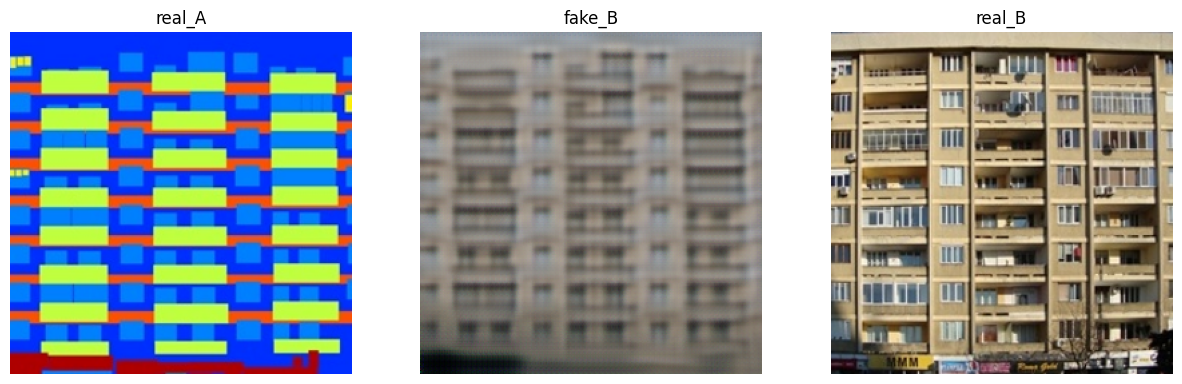

In [ ]:
total_iters = 0                # the total number of training iterations
for epoch in range(opt.epoch_count, opt.n_epochs + opt.n_epochs_decay + 1):    # outer loop for different epochs; we save the model by <epoch_count>, <epoch_count>+<save_latest_freq>
   # timer for entire epoch
   epoch_start_time = time.time()      iter_data_time = time.time()    # timer for data loading per iteration
   # the number of training iterations in current epoch, reset to 0 every epoch
   epoch_iter = 0                      #visualizer.reset()              # reset the visualizer: make sure it saves the results to HTML at least once every epoch
   # update learning rates in the beginning of every epoch.
   model.update_learning_rate()        for i, data in enumerate(dataset):  # inner loop within one epoch
       # timer for computation per iteration
       iter_start_time = time.time()          if total_iters % opt.print_freq == 0:
           t_data = iter_start_time - iter_data_time

       total_iters += opt.batch_size
       epoch_iter += opt.batch_size
       # unpack data from dataset and apply preprocessing
       model.set_input(data)                 model.optimize_parameters()   # calculate loss functions, get gradients, update network weights

       # display images on visdom and save images to a HTML file
       if total_iters % opt.display_freq == 0:               display.clear_output(wait=True)
           save_result = total_iters % opt.update_html_freq == 0
           model.compute_visuals()
          #visualizer.display_current_results(model.get_current_visuals(), epoch, save_result)
                       visuals = model.get_current_visuals()
           images = []
           fig = plt.figure(figsize=(15, 15))
           nvis = len(visuals)
           i = 0
           for label, image in visuals.items():
               image_numpy = util.tensor2im(image)
               plt.subplot(1, nvis, i+1)
               plt.title(label)
               plt.imshow(image_numpy)
               plt.axis('off')
               images.append(wandb.Image(image_numpy))
               i += 1
           plt.show()
           wandb.log({'Generated images': images})

       # print training losses and save logging information to the disk
       if total_iters % opt.print_freq == 0:                losses = model.get_current_losses()
           t_comp = (time.time() - iter_start_time) / opt.batch_size
          #visualizer.print_current_losses(epoch, epoch_iter, losses, t_comp, t_data)
                       #if opt.display_id > 0:
          #    visualizer.plot_current_losses(epoch, float(epoch_iter) / dataset_size, losses)
                       wandb.log(losses)

       # cache our latest model every <save_latest_freq> iterations
       #if total_iters % opt.save_latest_freq == 0:               #print('saving the latest model (epoch %d, total_iters %d)' % (epoch, total_iters))
          #save_suffix = 'iter_%d' % total_iters if opt.save_by_iter else 'latest'
                       #model.save_networks(save_suffix)

       iter_data_time = time.time()
   # cache our model every <save_epoch_freq> epochs
   #if epoch % opt.save_epoch_freq == 0:                  #    print('saving the model at the end of epoch %d, iters %d' % (epoch, total_iters))
  #    model.save_networks('latest')
       #    model.save_networks(epoch)

   print('End of epoch %d / %d \t Time Taken: %d sec' % (epoch, opt.n_epochs + opt.n_epochs_decay, time.time() - epoch_start_time))